In [2]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import cv2 as cv
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


from tobac_flow import io, abi
from tobac_flow.plotting import goes_figure
from tobac_flow.flow import Flow
from tobac_flow import legacy_flow as lf


In [3]:
# Load files
goes_data_path = '../data/GOES16'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = io.find_abi_files(dates, satellite=16, product='MCMIP', view='C', mode=3, 
                              save_dir=goes_data_path, 
                              replicate_path=True, check_download=True, 
                              n_attempts=1, download_missing=True)
             

abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))

# Get time difference (in seconds) between each file
dt = [(abi_dates[1]-abi_dates[0]).total_seconds()/60] \
     + [(abi_dates[i+2]-abi_dates[i]).total_seconds()/120 \
        for i in range(len(abi_files)-2)] \
     + [(abi_dates[-1]-abi_dates[-2]).total_seconds()/60]
dt = np.array(dt)

# Test with some multichannel data
ds_slice = {'x':slice(1325,1475), 'y':slice(725,850)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)

48


In [4]:
# Extract fields and load into memory
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
try:
    wvd = wvd.compute()
except AttributeError:
    pass

bt = goes_ds.CMI_C13
try:
    bt = bt.compute()
except AttributeError:
    pass

swd = goes_ds.CMI_C13 - goes_ds.CMI_C15
try:
    swd = swd.compute()
except AttributeError:
    pass

In [5]:
flow_kwargs = {'pyr_scale':0.5, 'levels':6, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

In [6]:
# Get growth_rate of the wvd field and find markers
from tobac_flow.detection import detect_growth_markers
wvd_growth, growth_markers = detect_growth_markers(flow, wvd)

In [7]:
# Watershed anvil regions connected to growth markers
from tobac_flow.detection import edge_watershed
inner_watershed = edge_watershed(flow, wvd-swd, growth_markers!=0, -5, -15)


In [8]:
from tobac_flow.analysis import filter_labels_by_length_and_mask
inner_labels = filter_labels_by_length_and_mask(flow.label(inner_watershed), growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(inner_labels!=0))
print('Detected anvils: n =', inner_labels.max())


Detected anvils: area = 123872
Detected anvils: n = 2


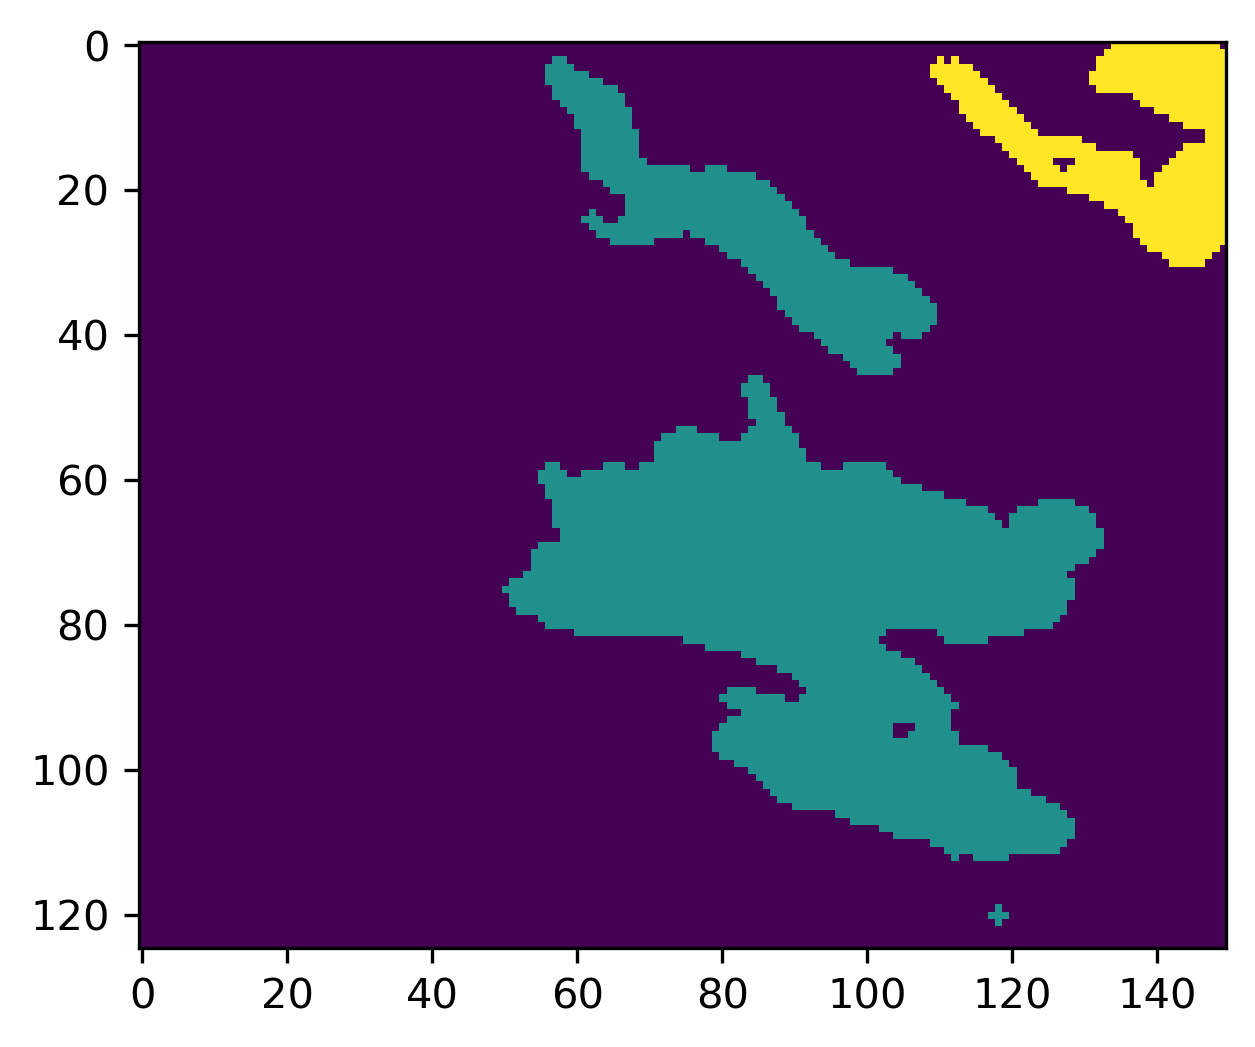

In [9]:
plt.figure(dpi=300)
plt.imshow(inner_labels[36])

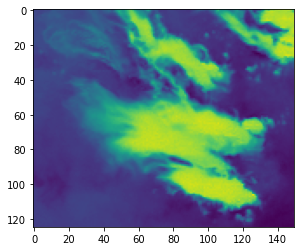

In [10]:
plt.imshow(wvd[36])

In [11]:
from tobac_flow.analysis import flat_label
flat_inner = flat_label(inner_labels)

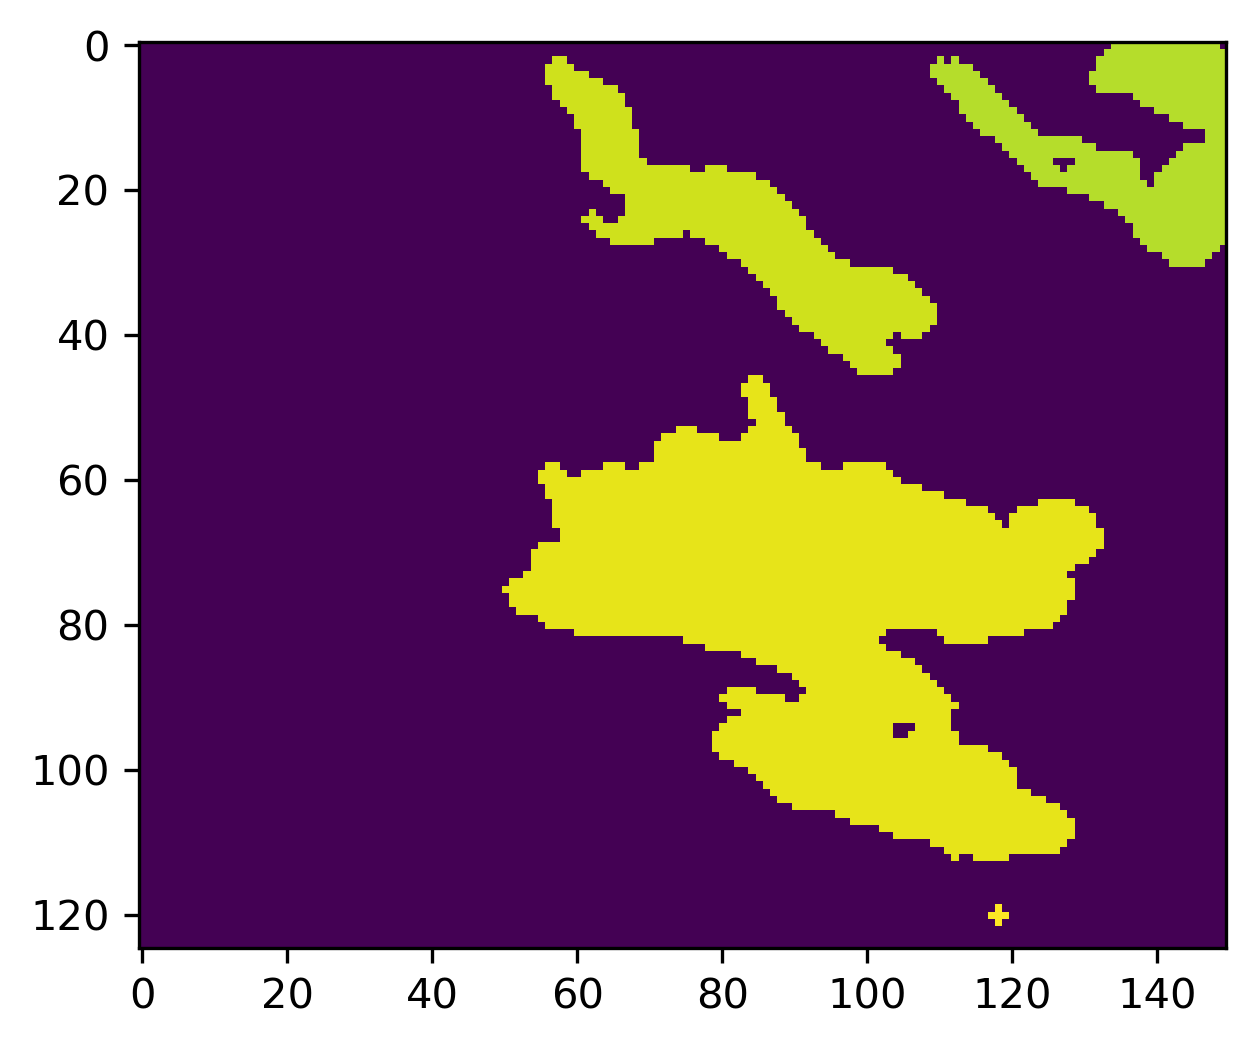

In [12]:
plt.figure(dpi=300)
plt.imshow(flat_inner[36],vmin=144)

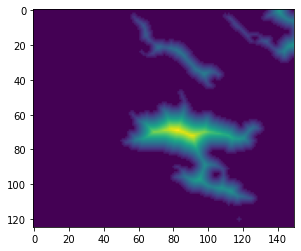

In [13]:
plt.imshow(ndi.morphology.distance_transform_edt(flat_inner[36]!=0))

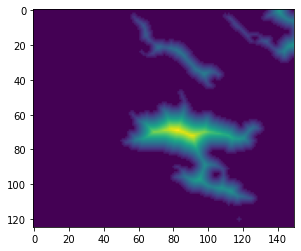

In [14]:
plt.imshow(ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])[36])

In [15]:
flat_inner_distances = ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])

In [16]:
flat_radii = (np.bincount(flat_inner.ravel())/np.pi)**0.5

In [17]:
flat_radii

array([497.04045645,   5.47002096,   2.03421447,   1.59576912,
         6.57952464,   2.82094792,   2.25675833,   7.69452005,
         3.09019362,   2.98541066,   8.53773764,   3.33779059,
         3.612576  ,   9.28773272,   4.06842895,   4.44243322,
         9.98153267,   7.33446459,   1.95441005,  10.63014626,
         8.29185959,   2.58544147,  11.14185153,   9.72306722,
         1.26156626,   3.14127466,  11.67204486,  10.92548431,
         1.59576912,   3.52336282,  12.2703128 ,  12.08735859,
         3.6563664 ,  12.85312534,  13.09843611,   3.9088201 ,
        13.57576606,  13.90014751,   4.10736217,   1.95441005,
        14.03687357,  14.67977496,   4.65242649,   2.52313252,
        14.46131374,   1.26156626,  15.26443044,   4.91849076,
        15.27485341,   1.26156626,   2.25675833,  15.92774244,
         5.41151638,  15.77714584,   1.59576912,   1.26156626,
         1.26156626,   3.19153824,  16.5452864 ,   6.02389633,
        16.39065416,   1.95441005,   1.26156626,   1.87

In [18]:
ndi.morphology.distance_transform_edt(flat_inner[36]!=0)

array([[0.        , 0.        , 0.        , ..., 2.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.23606798, 1.41421356,
        1.        ],
       [0.        , 0.        , 0.        , ..., 2.82842712, 2.23606798,
        2.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
np.bincount(flat_label(inner_labels[36][np.newaxis])[0].ravel())

array([14890,   552,   663,  2640,     5])

In [20]:
from tobac_flow.analysis import flat_label
flat_inner = flat_label(inner_labels)
pixel_counts = np.bincount(flat_inner.ravel())
dist_mask = ndi.morphology.distance_transform_edt(flat_inner, [1e9,1,1])/((pixel_counts/np.pi)**0.5)[flat_inner]

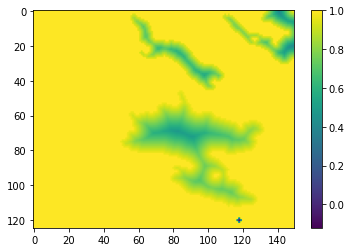

In [21]:
plt.imshow(1-dist_mask[36])
plt.colorbar()

In [22]:
thresh = 0.1

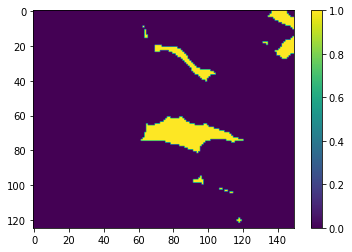

In [23]:
plt.imshow(dist_mask[36]>0.25)
plt.colorbar()

In [24]:
thresh = 0.1
shrunk_labels = flat_label(dist_mask>thresh)
shrunk_markers = shrunk_labels.copy()
shrunk_markers[flat_inner==0] = -1

In [25]:
struct = ndi.generate_binary_structure(3,1)
struct[0] = 0
struct[-1] = 0
subseg_labels = ndi.watershed_ift((np.minimum(dist_mask,1)*255).astype(np.uint8), shrunk_markers, struct)
subseg_labels[flat_inner==0] = 0

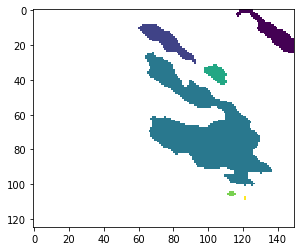

In [26]:
plt.imshow(ma.array(subseg_labels[23], mask=flat_inner[23]==0))

In [27]:
def subsegment_labels(input_mask, shrink_factor=0.1):
    from tobac_flow.analysis import flat_label
    from skimage.segmentation import watershed
    labels = flat_label(input_mask!=0)
    pixel_counts = np.bincount(labels.ravel())
    dist_mask = ndi.morphology.distance_transform_edt(labels, [1e9,1,1])/((pixel_counts/np.pi)**0.5)[labels]
    shrunk_labels = flat_label(dist_mask>shrink_factor)
    shrunk_markers = shrunk_labels.copy()
    shrunk_markers[flat_inner==0] = -1
    struct = ndi.generate_binary_structure(3,1)
    struct[0] = 0
    struct[-1] = 0
    subseg_labels = np.zeros_like(labels)
    for i in range(subseg_labels.shape[0]):
        subseg_labels[i] = watershed(-dist_mask[i], shrunk_markers[i], mask=flat_inner[i]!=0)
    
    return subseg_labels

In [28]:
subsegment_labels(inner_labels)[36]

array([[  0,   0,   0, ..., 215, 215,   0],
       [  0,   0,   0, ..., 215, 215, 215],
       [  0,   0,   0, ..., 215, 215, 215],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

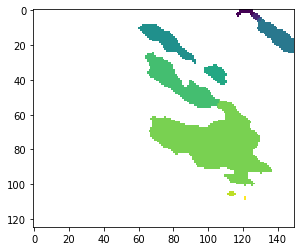

In [30]:
plt.imshow(ma.array(subsegment_labels(inner_labels, 0.25)[23], mask=flat_inner[23]==0))

In [62]:
# Improved version that also includes peaks of objects that have been "over-shrunk"
def subsegment_labels(input_mask, shrink_factor=0.1, peak_min_distance=5):
    from tobac_flow.analysis import flat_label
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    
    # Individually label regions at each time step
    labels = flat_label(input_mask!=0)
    
    # Calculate the distance from the edge of each region for pixels inside each labe;
    dist_mask = ndi.morphology.distance_transform_edt(labels, [1e9,1,1])
    pixel_counts = np.bincount(labels.ravel())
    dist_mask /= ((pixel_counts/np.pi)**0.5)[labels]
    
    shrunk_markers = dist_mask > shrink_factor
    
    # Find local maxima to see if we've missed any labels by "over-shrinking"    
    local_maxima = np.zeros_like(shrunk_markers)
    for i in range(local_maxima.shape[0]):
        maxima = peak_local_max(dist_mask[i], 
                                min_distance=peak_min_distance, 
                                threshold_abs=1e-8)
        local_maxima[i][tuple(maxima.T)] = True
    
    shrunk_markers = flat_label(np.logical_or(shrunk_markers, local_maxima))
    shrunk_markers[flat_inner==0] = -1
    
    struct = ndi.generate_binary_structure(3,1)
    struct[0] = 0
    struct[-1] = 0
    
    subseg_labels = np.zeros_like(labels)
    
    for i in range(subseg_labels.shape[0]):
        subseg_labels[i] = watershed(-dist_mask[i], shrunk_markers[i], mask=flat_inner[i]!=0)
    
    return subseg_labels, shrunk_markers, dist_mask

In [63]:
subseg_labels, shrunk_markers, dist_mask = subsegment_labels(inner_labels, 0.25)

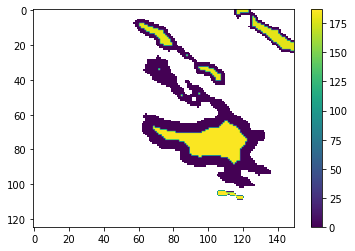

In [64]:
plt.imshow(ma.array(shrunk_markers[25], mask=flat_inner[25]==0))
plt.colorbar()

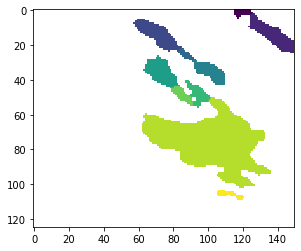

In [65]:
plt.imshow(ma.array(subseg_labels[25], mask=flat_inner[25]==0))

In [88]:
# Improved version that also includes peaks of objects that have been "over-shrunk"
def subsegment_labels(input_mask, shrink_factor=0.1, peak_min_distance=5):
    """Takes a 3d array (t,y,x) of regions and splits each label at each time step 
    into multiple labels based on morphology.
    
    Parameters
    ----------
    input_mask : nd.array
        A 3d array of in which non-zero values are treated as regions of interest
    shrink_factor : float - optional
        The proportion of the approximate radius to shrink each object. Defaults to 
        0.1
    peak_min_distance : int - optional
        The minimum distance between neighbouring peaks for additional maxima added 
        to the subsegment markers. Defaults to 5
    
    Returns
    -------
    subseg_labels : nd.array
        A 3d array of labels, where each subsegment label at each time step has an 
        individual integer value. Same size as input_mask
    
    The splitting is performed by approximating each region as a circle, calculating 
    an approximate radius from the area, and then shrinking each region by the 
    approximate radius times the 'shrink_factor'. Objects that are more irregular in 
    shape will be shrunk more than those that have more regular shapes. Each separate 
    section of the region is given its own label, and the original region is segmented 
    between them by watershedding. To ensure that smaller objects are not eroded by 
    the shrinking process, maxima in the distance from the field to the edge of each 
    region are also included as seeds to the watershed.
    """
    
    from tobac_flow.analysis import flat_label
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    
    # Individually label regions at each time step
    labels = flat_label(input_mask!=0)
    
    # Calculate the distance from the edge of each region for pixels inside each labe;
    dist_mask = ndi.morphology.distance_transform_edt(labels, [1e9,1,1])
    pixel_counts = np.bincount(labels.ravel())
    dist_mask /= ((pixel_counts/np.pi)**0.5)[labels]
    
    shrunk_markers = dist_mask > shrink_factor
    
    # Find local maxima to see if we've missed any labels by "over-shrinking"    
    local_maxima = np.zeros_like(shrunk_markers)
    for i in range(local_maxima.shape[0]):
        maxima = peak_local_max(dist_mask[i], 
                                min_distance=peak_min_distance, 
                                threshold_abs=1e-8)
        local_maxima[i][tuple(maxima.T)] = True
    
    shrunk_markers = flat_label(np.logical_or(shrunk_markers, local_maxima))
    shrunk_markers[flat_inner==0] = -1
    
    struct = ndi.generate_binary_structure(3,1)
    struct[0] = 0
    struct[-1] = 0
    
    subseg_labels = np.zeros_like(labels)
    
    for i in range(subseg_labels.shape[0]):
        subseg_labels[i] = watershed(-dist_mask[i], shrunk_markers[i], mask=flat_inner[i]!=0)
    
    return subseg_labels

# implement minimum overlap for flow_label function
def flow_label(flow, 
               mask, 
               structure=ndi.generate_binary_structure(3,1), 
               dtype=np.int32, 
               overlap=0., 
               subsegment_shrink=0., 
               peak_min_distance=10):
    """Label 3d connected objects in a semi-Lagrangian reference frame
    
    Parameters
    ----------
    flow : Flow object
        The flow-field object corresponding to the mask being labelled
    mask : nd_array
        A 3d array of in which non-zero values are treated as regions to be 
        labelled
    structure : nd.array - optional
        A (3,3,3) boolean array defining the connectivity between each point 
        and its neighbours. Defaults to square connectivity
    dtype : dtype - optional
        Dtype for the returned labelled array. Defaults to np.int32
    overlap : float - optional
        The required minimum overlap between subsequent labels (when accounting 
        for Lagrangian motion) to consider them a continous object. Defaults to
        0.
    subsegment_shrink : float - optional
        The proportion of each regions approximate radius to shrink it by when 
        performing subsegmentation. If 0 subsegmentation will not be performed. 
        Defaults to 0.
    peak_min_distance : int - optional
        The minimum distance between maxima allowed when performing subsegmentation. 
        Defaults to 5
    
    """
    from tobac_flow.analysis import flat_label
    from collections import deque
#     Get flat (2d) labels
    if subsegment_shrink == 0:
        flat_labels = flat_label(mask.astype(bool), structure=structure).astype(dtype)
    else:
        flat_labels = subsegment_labels(mask.astype(bool), shrink_factor=subsegment_shrink)

    back_labels, forward_labels = flow.convolve(flat_labels, method='nearest', dtype=dtype,
                                                structure=structure*np.array([1,0,1])[:,np.newaxis, np.newaxis])
    
    processed_labels = []
    label_map = {}
    
    bins = np.cumsum(np.bincount(flat_labels.ravel()))
    args = np.argsort(flat_labels.ravel())
    
    for label in range(1, bins.size):
        if label not in processed_labels:
            label_map[label] = [label]
            processed_labels.append(label)

            i = 0
            while i < len(label_map[label]):
                find_neighbour_labels(label_map[label][i], label_map[label], bins, args,
                                      processed_labels, forward_labels, back_labels,
                                      overlap=overlap)
                i+=1
    
    new_labels = np.zeros(mask.shape, dtype=dtype)

    for ik, k in enumerate(label_map):
        for i in label_map[k]:
            if bins[i]>bins[i-1]:
                new_labels.ravel()[args[bins[i-1]:bins[i]]] = ik+1

    assert np.all(new_labels.astype(bool)==mask.astype(bool))
    return new_labels

def find_neighbour_labels(label, label_stack, bins, args, processed_labels,
                          forward_labels, back_labels, overlap=0):
    """
    Find the neighbouring labels at the previous and next time steps to a given
    label
    """
    if bins[label]>bins[label-1]: #check that there are any pixels in this label
        forward_lap = forward_labels.ravel()[args[bins[label-1]:bins[label]]]
        forward_bins = np.bincount(np.maximum(forward_lap,0))
        for new_label in np.unique(forward_lap):
            if (new_label>0 and 
                new_label not in processed_labels and 
                forward_bins[new_label] >= overlap*np.minimum(bins[label]-bins[label-1], bins[new_label]-bins[new_label-1])):
                
                label_stack.append(new_label)
                processed_labels.append(new_label)
                
        backward_lap = back_labels.ravel()[args[bins[label-1]:bins[label]]]
        backward_bins = np.bincount(np.maximum(backward_lap,0))
        for new_label in np.unique(backward_lap):
            if (new_label>0 and 
                new_label not in processed_labels and 
                backward_bins[new_label] >= overlap*np.minimum(bins[label]-bins[label-1], bins[new_label]-bins[new_label-1])):
                
                label_stack.append(new_label)
                processed_labels.append(new_label)


In [89]:
test_labels = filter_labels_by_length_and_mask(flow_label(flow, inner_watershed, overlap=0.75, subsegment_shrink=0.25), growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(test_labels!=0))
print('Detected anvils: n =', test_labels.max())


Detected anvils: area = 123285
Detected anvils: n = 4


In [90]:
np.bincount(test_labels.ravel())

array([776715,  14890,  76601,  15458,  16336])

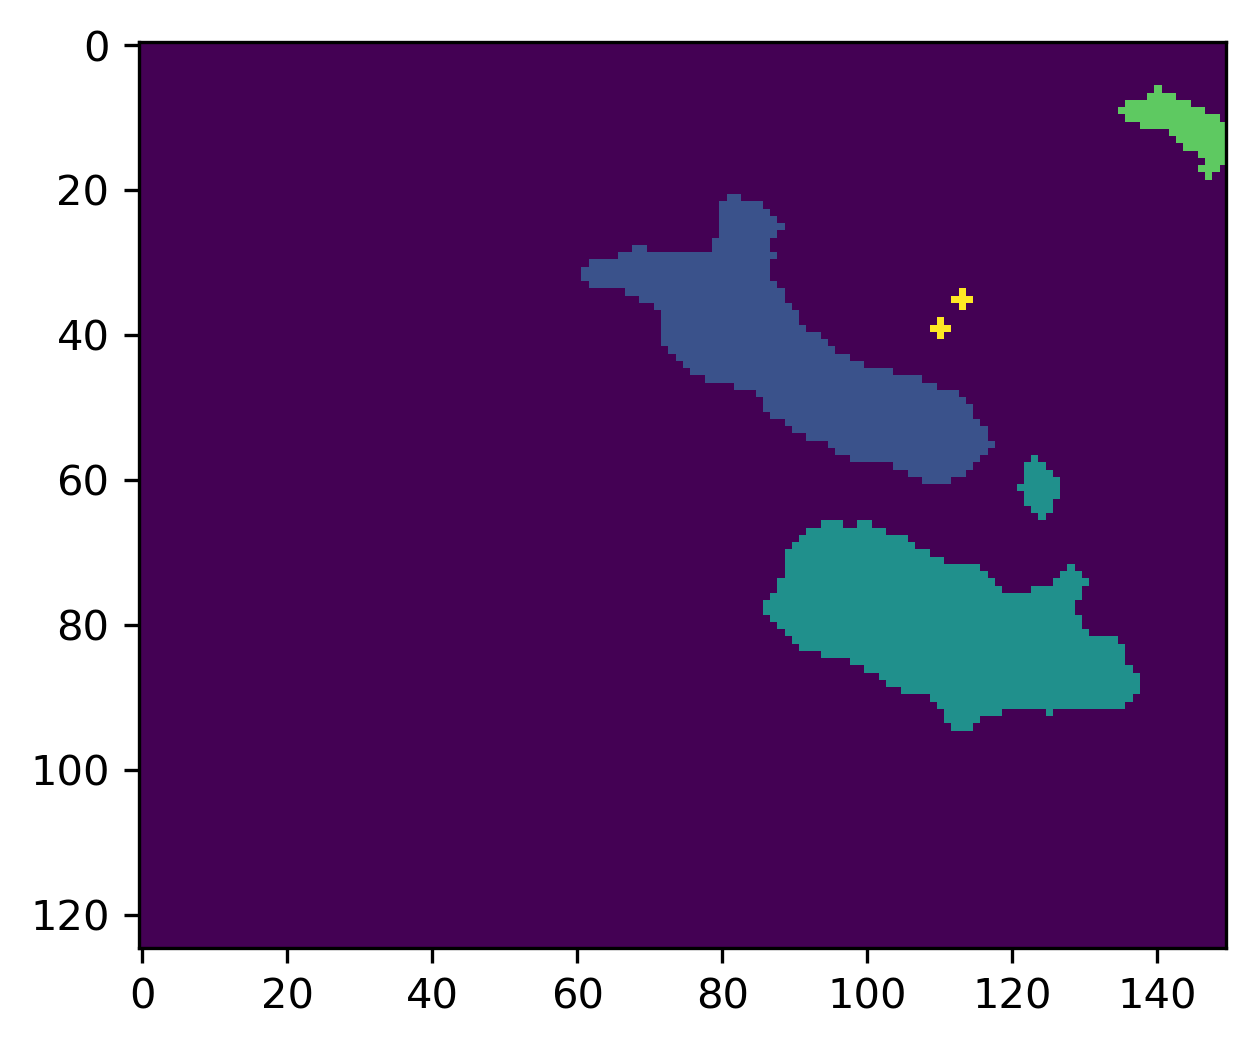

In [98]:
plt.figure(dpi=300)
plt.imshow(test_labels[15])

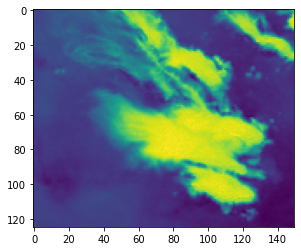

In [101]:
plt.imshow(wvd[31])

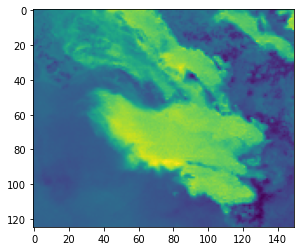

In [104]:
plt.imshow(wvd[31]+swd[31])

In [146]:
flow._warp_flow_step?

In [147]:
stencil = ndi.generate_binary_structure(2,1)

In [150]:
np.where(stencil)

(array([0, 1, 1, 1, 2]), array([1, 0, 1, 2, 1]))

In [27]:
def _warp_flow_step(self, img, step, method='linear', direction='forward', 
                    stencil=ndi.generate_binary_structure(2,1)):
    if img.shape != self.shape[1:]:
        raise ValueError("Image shape does not match flow shape")
    if method == 'linear':
        method = cv.INTER_LINEAR
    elif method =='nearest':
        method = cv.INTER_NEAREST
    else:
        raise ValueError("method must be either 'linear' or 'nearest'")
    
    h, w = self.shape[1:]
    n = np.sum(stencil!=0)
    offsets = np.stack(np.where(stencil!=0), -1)[:,np.newaxis,np.newaxis,:]-1
    locations = np.tile(offsets, [1,h,w,1]).astype(np.float32)
    locations += np.stack(np.meshgrid(np.arange(w), np.arange(h)), -1)
    if direction=='forward':
        locations += self.flow_for[step]
    elif direction=='backward':
        locations += self.flow_back[step]
    
    out_img = np.full([n,h*2], np.nan).astype(img.dtype)
    return cv.remap(img, locations.reshape([n,-1,2]), None, 
                        method, out_img, cv.BORDER_CONSTANT, np.nan).reshape([n,h,w])
    

In [28]:
_warp_flow_step(flow, bt[24].data, 24)

array([[[      nan, 297.14786, 298.3155 , ..., 285.7655 , 287.81454,
               nan],
        [      nan, 297.14786, 299.42163, ..., 285.71036, 283.737  ,
               nan],
        [      nan, 298.0082 , 298.4384 , ..., 279.0434 , 282.83597,
         286.69397],
        ...,
        [      nan, 296.1646 , 296.1646 , ..., 302.0027 , 302.67865,
         223.93704],
        [      nan, 296.10315, 296.04172, ..., 302.30994, 301.5725 ,
         229.98708],
        [      nan,       nan,       nan, ..., 242.01631, 239.33638,
         237.5324 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [297.14786, 298.3155 , 297.3322 , ..., 288.88904, 286.98328,
               nan],
        [297.14786, 299.42163, 296.2875 , ..., 283.89175, 284.75967,
               nan],
        ...,
        [296.2875 , 296.22607, 296.2875 , ..., 301.75687, 301.81833,
         217.67743],
        [296.1646 , 296.1646 , 296.1646 , ..., 302.67865, 302.98593,
   

In [172]:
before = flow.sobel(bt)
%timeit flow.sobel(bt)

754 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


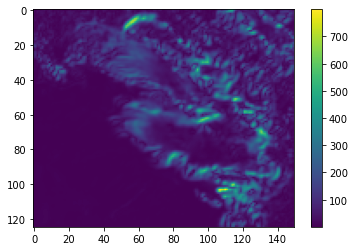

In [174]:
plt.imshow(before[24])
plt.colorbar()

In [176]:
from importlib import reload
import tobac_flow
reload(tobac_flow)
from tobac_flow.flow import Flow
flow_kwargs = {'pyr_scale':0.5, 'levels':6, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

In [10]:
after = flow.sobel(bt)
%timeit flow.sobel(bt)

589 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


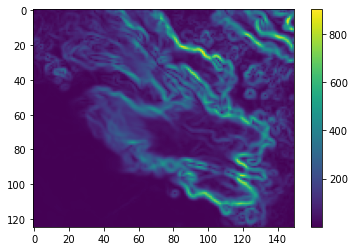

In [27]:
plt.imshow(after[31])
plt.colorbar()

In [6]:
test = flow.convolve(bt, structure=np.ones((3,3,3)))

In [7]:
test.shape

(27, 48, 125, 150)

In [8]:
np.all(test[13,24]==bt[24])

<xarray.DataArray 'CMI_C13' ()>
array(True)
Coordinates:
    t        datetime64[ns] 2018-06-19T19:03:43.334675968
    y_image  float32 0.08624
    x_image  float32 -0.03136

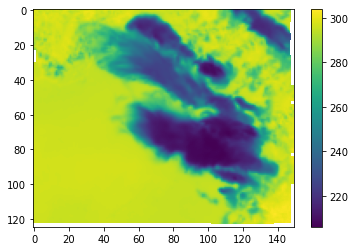

In [12]:
plt.imshow(test[5,24])
plt.colorbar()